In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

from preprocess_outputs import preprocess_crt_avpu
from datasets import create_dataloaders, IMPALA_Dataset

CLINICAL_DATA_PATH = './../DATA/Clean Data/IMPALA_Clinical_Data_202308211019_Raw.csv'
CLINICAL_DTYPES_PATH = './../DATA/IMPALAclinicalstudy_Dictionary_2023-09-25.csv'

### Load data

In [2]:

def read_clinical_df(path):
    """ Load clinical data into a Pandas DataFrame. """
    return pd.read_csv(path, low_memory=False)


def read_clinical_dtype_dict(path):
    """ Load clinical dict containing all variable names and their properties. """

    df = pd.read_csv(path)
    df = df[df['Variable'].str.startswith(tuple(['recru', 'dly', 'record_id']))]

    dtype_dict = defaultdict(list)

    for _, row in df.iterrows():
        dtype_dict[row['Field Type']].append(row['Variable'])
    
    # {k: v.append('dly_time') for k, v in dtype_dict.items()}
    del df

    return dtype_dict


In [3]:

clinical_df = read_clinical_df(CLINICAL_DATA_PATH)
dtype_dict = read_clinical_dtype_dict(CLINICAL_DTYPES_PATH)

# Checkbox column names in dtype_df do not correspond 1-on-1 with clinical data
checkbox_dict = {
    'recru_hdu_admission_reason' : ['recru_resp', 'recru_circu', 'recru_neuro',
                                    'recru_nurse', 'recru_unclear', 'recru_hdu_other'],
    'recru_medication_specfy' : clinical_df.columns[clinical_df.columns.str.startswith('recru_medication_specfy___')].to_list(),
    'dly_new_drug' : clinical_df.columns[clinical_df.columns.str.startswith('dly_new_drug___')].to_list(),
}

dtype_dict['checkbox'] = [l for s in checkbox_dict.values() for l in s]
# dtype_dict['checkbox'].append('dly_time')


### Cleaning data

#### Split data per datatype

In [4]:

def intersection(l1, l2):
    """ Create intersection of two lists. """
    return [v1 for v1 in l1 if v1 in l2]


def split_per_dtype(c_df, d_dict):
    """
    Split the clinical dataset per datatype.
    """

    c_df = c_df.copy()  # Might remove later
    d_dict = d_dict.copy() # Might remove later

    # Remove rows that have no daily time (as those are duplicates of the row above)
    c_df = c_df[-pd.isna(c_df['dly_time'])]
    c_df.reset_index(inplace=True)

    # Replace missing values with -1
    c_df.replace(to_replace=99, value=-1, inplace=True)
    c_df.fillna(-1, inplace=True)

    # Only select columns that appear in clinical data
    dtype_columns = {k : intersection(v, c_df.columns.to_list()) for k, v in d_dict.items()}
    dtype_df = {k : c_df[v] for k, v in dtype_columns.items()}

    return dtype_df


In [5]:

dtype_df = split_per_dtype(clinical_df, dtype_dict)


#### Remove columns if too many values are missing

In [6]:

def remove_columns(dtype_df, threshold):
    """ Remove columns if the ratio of missing values exceeds the threshold. """

    for type_, df in dtype_df.items():
        drop = []

        for col in df:
            if -1 in df[col].value_counts(normalize=True).to_dict().keys() and \
                    df[col].value_counts(normalize=True).to_dict()[-1] > threshold:

                drop.append(col)
        
        print(f'{type_}: removed {len(drop)} columns')
        dtype_df[type_] = dtype_df[type_].drop(drop, axis=1)
    
    return dtype_df


In [7]:

dtype_df = remove_columns(dtype_df, 0.8)


text: removed 93 columns
radio: removed 174 columns
yesno: removed 0 columns
checkbox: removed 0 columns
calc: removed 0 columns


#### Preprocess text and categorical

In [8]:

def split_text_data(dtype_df):
    """
    Split the text data into numerical, record_id, dates and text
    """

    dtype_df = dtype_df.copy()

    # Split numerical columns
    if 'num' not in dtype_df.keys():
        num_df = dtype_df['text'].select_dtypes(include=['float64', 'int64'])
        valid_num_columns = num_df.columns.to_list()
        dtype_df['text'] = dtype_df['text'].drop(valid_num_columns, axis=1)
        dtype_df['num'] = num_df

    # Split record_id
    if 'record_id' in dtype_df['text'].columns:
        record_id = dtype_df['text']['record_id']
        dtype_df['text'] = dtype_df['text'].drop('record_id', axis=1)
        dtype_df['record_id'] = record_id

    # Split date columns (columns handpicked)
    if 'dates' not in dtype_df.keys():
        date_df = dtype_df['text'].filter(
            ["recru_interview_date_", "recru_hospital_admission_date",
            "recru_hdu_admission_date", "recru_dob", "recru_bloodculture_time",
            "recru_lactate_sample_time", "recru_storage_spec_time",
            "recru_nasal_swab_time", "recru_urine_time", "dly_time",
            "dly_time_new_cie1a", "dly_time_new_cie2", "dly_time_new_cie3",
            "dly_time_new_cie4", "dly_time_new_cie5", "dly_time_new_cie6"])
        
        dtype_df['dates'] = date_df
        dtype_df['text'] = dtype_df['text'].drop(date_df.columns, axis=1)

    return dtype_df


def one_hot_encoding(df):
    """
    Convert categorical columns to multiple binary columns and add them to the
    end of the DataFrame. Remove binary columns that are created for
    missing/NaN values.
    """

    df = df.copy()

    categorical_columns = df.columns.to_list()
    drop = []

    for col in categorical_columns:

        if -1 in df[col].value_counts().to_dict().keys():
            DROP_FIRST = True

        else:
            DROP_FIRST = False

        df = df.join(pd.get_dummies(df[col],
                                    dummy_na=False, 
                                    prefix=col,
                                    sparse=True,
                                    drop_first=DROP_FIRST,
                                    dtype=float))

        # Drop original categorical column
        drop.append(col)

    df = df.drop(drop, axis=1)

    return df


In [9]:

dtype_df = split_text_data(dtype_df)

filter_ = dtype_df['radio'].filter(['recru_avpu_score', 'dly_avpu'])
dtype_df['radio'] = dtype_df['radio'].drop(filter_, axis=1)

filter_ = dtype_df['num'].filter(['recru_cr_time_result', 'dly_crt'])
dtype_df['num'] = dtype_df['num'].drop(filter_, axis=1)

dtype_df['radio'] = one_hot_encoding(dtype_df['radio'])


In [10]:

dtype_df['num'].insert(0, 'dly_hour',
                       pd.to_datetime(dtype_df['dates']['dly_time'],
                                      format='mixed').round('h').dt.hour)


#### Normalize data

In [11]:

numerical_dtypes = ['radio', 'yesno', 'checkbox', 'calc', 'num']
string_dtypes = ['text', 'record_id', 'dates']

numerical_data = np.concatenate(([v for k, v in dtype_df.items() \
                                  if k in numerical_dtypes]), axis=1)

# Normalize the data
data = normalize(numerical_data, axis=0)


### Principal Component Analysis

In [12]:

def perform_PCA(data, visualize=True):
    """
    Normalize the data and perform PCA to reduce dimensionality.
    If visualize is True, plot the explained variance per PC.
    """

    # Perform Principal Component Analysis
    pca = PCA(n_components='mle')
    pca.fit(data)
    new_data = pca.transform(data)

    if visualize:
        plt.plot(range(pca.n_components_), pca.explained_variance_ratio_)
        plt.title('Explained variance ratio per principal component')
        plt.xlabel('Number of components')
        plt.ylabel('Ratio of explained variance')
        plt.legend(['Explained Variance', "Number of PCs found using Minka's MLE"])
        plt.tight_layout()
        plt.show()

    return new_data


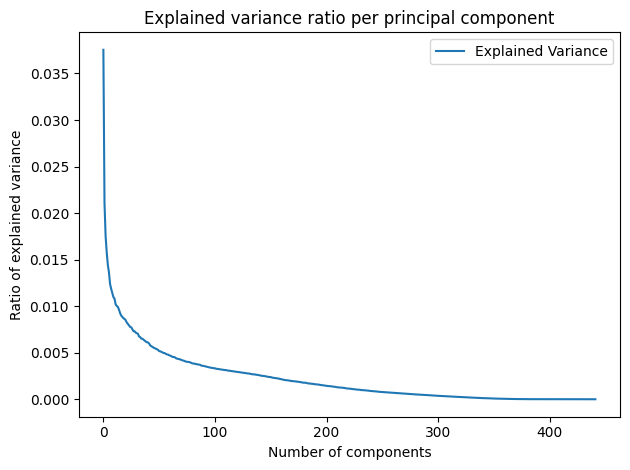

In [13]:

data = perform_PCA(data, visualize=True)


### Sliding window

In [14]:

outputs = preprocess_crt_avpu(CLINICAL_DATA_PATH)


In [15]:

def sliding_window_backward(data, outputs, datetimes, admission_dates, record_ids, sample_window_hours):
    """
    Apply a sliding window over the given data.
    :param data:     NumPy Array containing the clinical data.
    :param outputs:  Pandas Dataframe containing CRT and AVPU values per time.
    :param datetimes: Pandas DataFrame containing the time at each data point.
    :param record_ids: Pandas DataFrame containing the record IDs per patient.
    """
    
    X, y = [], []

    for record_id, df in record_ids.groupby(by='record_id', observed=True):

        idx = df.index
        del df

        curr_data = data[idx, :]
        curr_output = outputs[record_id]
        curr_datetime = datetimes.iloc[idx]

        curr_data = np.concatenate((curr_data[0:1, :], curr_data))
        curr_datetime = pd.concat([pd.Series(admission_dates[record_id]), curr_datetime],
                                  ignore_index=True)
        curr_datetime = pd.to_datetime(curr_datetime, format='mixed')

        for end in curr_datetime[::-1]:

            start = end - pd.Timedelta(sample_window_hours, unit='h')
            idx = curr_datetime.between(start, end)
            window = curr_data[idx]

            if window.shape[0] < (sample_window_hours / 4) + 1:
                continue

            elif window.shape[0] > (sample_window_hours / 4) + 1: # Remove first entry
                window = window[-int((sample_window_hours / 4) + 1):]
            
            # Calculate to which output the end of the window lies closest
            nearest_output_idx = np.argmin( [abs(end - t) for t in curr_output.index] )

            X.append(window.T)
            y.append(curr_output.iloc[nearest_output_idx].values)

    X = np.array(X) # Shape: samples, dimensions, time
    y = np.array(y) # Shape: samples, dimensions

    print(X.shape)
    print(y.shape)

    return X, y


In [16]:

datetimes = dtype_df['dates']['dly_time']
admission_dates = {k : v['recru_hospital_admission_date'].iloc[0] for \
                   k, v in clinical_df.groupby('record_id')}

X, y = sliding_window_backward(data, outputs, datetimes, admission_dates,
                      dtype_df['record_id'].to_frame(), 12)


(5138, 442, 4)
(5138, 2)


In [17]:

def sliding_window_forward(data, outputs, datetimes, admission_dates, record_ids, sample_window_hours):
    """
    Apply a sliding window over the given data.
    :param data:     NumPy Array containing the clinical data.
    :param outputs:  Pandas Dataframe containing CRT and AVPU values per time.
    :param datetimes: Pandas DataFrame containing the time at each data point.
    :param record_ids: Pandas DataFrame containing the record IDs per patient.
    """
    
    X, y = [], []

    for record_id, df in record_ids.groupby(by='record_id', observed=True):

        idx = df.index
        del df
        curr_data = data[idx, :]
        curr_output = outputs[record_id]
        curr_datetime = datetimes.iloc[idx]

        curr_data = np.concatenate((curr_data[0:1, :], curr_data))
        curr_datetime = pd.concat([pd.Series(admission_dates[record_id]), curr_datetime],
                                  ignore_index=True)
        curr_datetime = pd.to_datetime(curr_datetime, format='mixed')

        for start in curr_datetime:

            end = start + pd.Timedelta(sample_window_hours, unit='h')
            idx = curr_datetime.between(start, end)
            window = curr_data[idx]

            # Only continue if window is the appropriate size (5016 windows)
            if window.shape[0] == (sample_window_hours / 4) + 1:

                # Calculate to which output the end of the window lies closest
                nearest_output_idx = np.argmin( [abs(end - t) for t in curr_output.index] )

                X.append(window.T)
                y.append(curr_output.iloc[nearest_output_idx].values)


    X = np.array(X) # Shape: samples, dimensions, time
    y = np.array(y) # Shape: samples, dimensions

    print(X.shape)
    print(y.shape)

    return X, y


In [18]:

# datetimes = dtype_df['dates']['dly_time']
# admission_dates = {k : v['recru_hospital_admission_date'].iloc[0] for \
#                    k, v in clinical_df.groupby('record_id')}

# X, y = sliding_window_forward(data, outputs, datetimes, admission_dates,
#                       dtype_df['record_id'].to_frame(), 8)


### Turn data to PyTorch DataLoaders

In [19]:

clinical_dataset = IMPALA_Dataset(X, y)

train_dataloader, val_dataloader, test_dataloader = \
        create_dataloaders(clinical_dataset, batch_size=32)
